# Classification of Breast cancer Ultrasound Images Using  Convolutional Neural Networks

### Importing required Libraries 

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

### Importing given dataset 

Soure : https://scholar.cu.edu.eg/?q=afahmy/pages/dataset

In [3]:
path = '../M7016H/breast-ultrasound-images-dataset/'

### Data ingestion and Data preparation

In [5]:
def num (image):
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

In [6]:
#x for images,#y for masks and #t for target"label"
X_benign, y_benign = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_normal, y_normal = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_malignant, y_malignant= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [7]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # Here reading the image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_benign[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_normal[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_malignant[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_benign[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_normal[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_malignant[num(image)-1]+= img_to_array(pil_img)

### Concatenating the X and y for all the three classes.

In [8]:
X = np.concatenate((X_benign, X_normal, X_malignant), axis = 0)
y = np.concatenate((y_benign,y_normal,  y_malignant), axis = 0)

In [9]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


### Important Function

In [10]:
#convert image to one channel 
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [11]:
#convert from one image to three channel   
    def convertToThreeChannel(img):
        b_np= np.array(img)
        g_np= np.array(img)
        r_np= np.array(img)
        final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
        return np.array(final_img)

### Here we can  visualize image and mask 

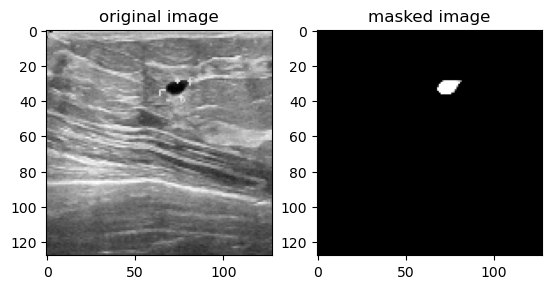

In [12]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

### Data Augmentation 

In [13]:
actual=[]
mask=[]
for i in X:
    horizontal_flip = cv2.flip(i, 1)
  vertical_horizontal_flip = cv2.flip(i, -1)
  imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
  imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
  imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
  actual.append(horizontal_flip)
  actual.append(vertical_horizontal_flip)
  actual.append(imagerotate)
  actual.append(imagerotate1)
  actual.append(imagerotate2)
  

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [14]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [15]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [16]:
mask[mask > 1.0] = 1.0

In [17]:
print(mask.max())
print(mask.min())


1.0
0.0


In [18]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


### Sample augmented image.

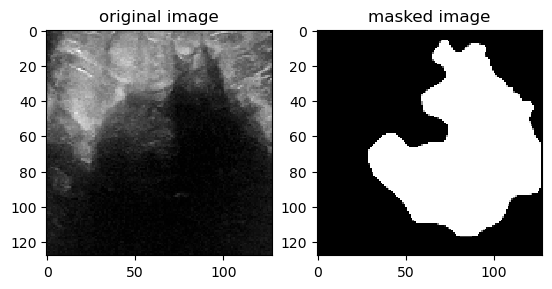

In [21]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

###  Split the data into Train and Test

In [22]:

X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)


In [24]:
print(X_train.shape)
print(X_test.shape)

(3315, 128, 128)
(585, 128, 128)


###  Build UNet Model 

In [25]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

In [26]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [27]:

tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [28]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

In [2]:
from keras.metrics import MeanIoU

In [30]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

###  Train the Model 

In [31]:
from keras.callbacks import ModelCheckpoint

In [32]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

We will keep the batch size as 64 and will train our model for 50 epochs.

In [33]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/50


2023-04-18 14:13:52.113930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


52/52 [==============================] - 102s 1s/step - loss: 0.0740 - acc: 0.9192 - val_loss: 0.0620 - val_acc: 0.9287
Epoch 2/50
52/52 [==============================] - 50s 957ms/step - loss: 0.0622 - acc: 0.9227 - val_loss: 0.0626 - val_acc: 0.9295
Epoch 3/50
52/52 [==============================] - 50s 953ms/step - loss: 0.0560 - acc: 0.9292 - val_loss: 0.0556 - val_acc: 0.9330
Epoch 4/50
52/52 [==============================] - 50s 962ms/step - loss: 0.0530 - acc: 0.9324 - val_loss: 0.0523 - val_acc: 0.9342
Epoch 5/50
52/52 [==============================] - 50s 965ms/step - loss: 0.0481 - acc: 0.9371 - val_loss: 0.0515 - val_acc: 0.9339
Epoch 6/50
52/52 [==============================] - 50s 967ms/step - loss: 0.0458 - acc: 0.9399 - val_loss: 0.0526 - val_acc: 0.9319
Epoch 7/50
52/52 [==============================] - 50s 963ms/step - loss: 0.0452 - acc: 0.9406 - val_loss: 0.0446 - val_acc: 0.9409
Epoch 8/50
52/52 [==============================] - 50s 963ms/step - loss: 0.0431 

### Visualization of  Accuracy and loss Graph

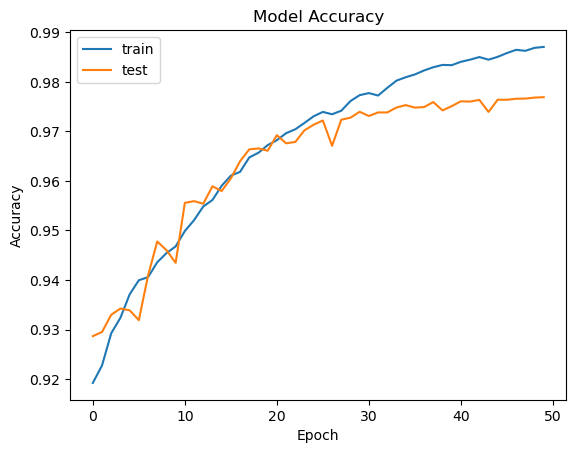

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

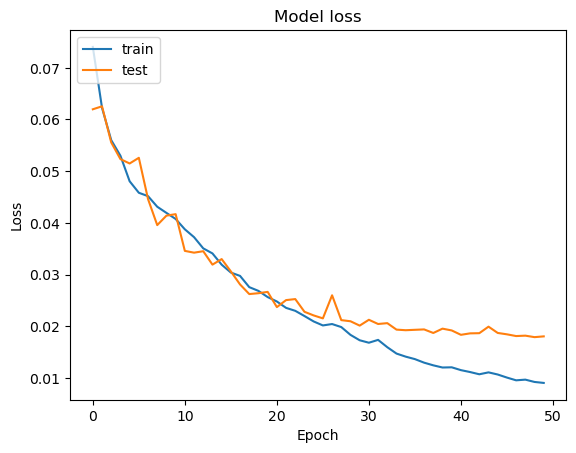

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Calculate accuracy and loss 

In [40]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

19/19 [==============================] - 8s 118ms/step - loss: 0.0180 - acc: 0.9769
Test loss: 0.01803506352007389
Test accuracy: 97.69004583358765


The test accuracy we got is around **97.69%** and the model loss was found to be **0.018**.

In [46]:
y_pred = model.predict(X_test)

19/19 [==============================] - 2s 117ms/step


## Save the model 

In [41]:
model.save("finalunet.h5")

# Testing our model 

In [42]:
def imgpredicting(img):
 x=[]
 x.append(img)
 x=np.array(x)
 output=model.predict(x)
 #print(output)
 output=np.array(output)
 output.shape
 array = np.reshape(output[0], (128, 128))
 print(array.shape)
 return array

1/1 [==============================] - 1s 1s/step
(128, 128)


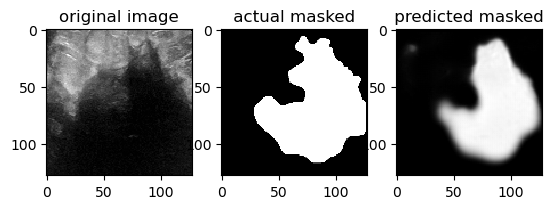

In [43]:
# Test image 1
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()


1/1 [==============================] - 0s 27ms/step
(128, 128)


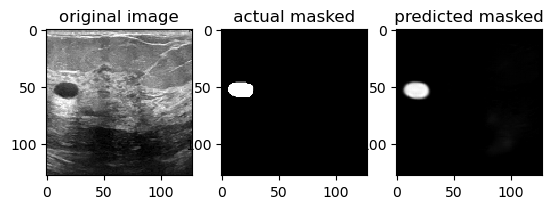

In [44]:
#Let us test on another image
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[500],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[500],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[500]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()


### Building our own classifier to classify if the given image is benign, normal or malignant.

## Let us now make our CNN model

In [66]:
def conv_block (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), strides = 1, padding = 'same', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    model.add(MaxPooling2D())
    
    return model

def dense_block(hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model

In [67]:
def cnn_model(filter1, filter2, filter3, filter4, hidden1) :
    
    model = Sequential([
        
        Input((128,128,1,)),
        conv_block(filter1),
        conv_block(filter2),
        conv_block(filter3),
        conv_block(filter4),
        Flatten(),
        dense_block(hidden1),
        Dense(3, activation = 'softmax')
    ])
    
    #compiling our model
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
    
    return model

In [69]:
from keras.layers import LeakyReLU
model = cnn_model(32, 64, 128, 256, 32)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 32)        448       
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 64)        18752     
                                                                 
 sequential_3 (Sequential)   (None, 16, 16, 128)       74368     
                                                                 
 sequential_4 (Sequential)   (None, 8, 8, 256)         296192    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 sequential_5 (Sequential)   (None, 32)                524448    
                                                                 
 dense_1 (Dense)             (None, 3)                

In [71]:
checkp = ModelCheckpoint('./valid_classifier_version3.h5', monitor = 'val_loss', save_best_only = True, verbose = 2)
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/400


2023-04-18 15:28:30.455493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/sequential_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8/8 [==============================] - ETA: 0s - loss: 4.7758 - accuracy: 0.5301
Epoch 1: val_loss improved from inf to 4.73264, saving model to ./valid_classifier_version3.h5
8/8 [==============================] - 8s 291ms/step - loss: 4.7758 - accuracy: 0.5301 - val_loss: 4.7326 - val_accuracy: 0.1786
Epoch 2/400
8/8 [==============================] - ETA: 0s - loss: 4.3619 - accuracy: 0.6044
Epoch 2: val_loss improved from 4.73264 to 4.69877, saving model to ./valid_classifier_version3.h5
8/8 [==============================] - 1s 137ms/step - loss: 4.3619 - accuracy: 0.6044 - val_loss: 4.6988 - val_accuracy: 0.1786
Epoch 3/400
8/8 [==============================] - ETA: 0s - loss: 4.0697 - accuracy: 0.6446
Epoch 3: val_loss improved from 4.69877 to 4.58964, saving model to ./valid_classifier_version3.h5
8/8 [==============================] - 1s 135ms/step - loss: 4.0697 - accuracy: 0.6446 - val_loss: 4.5896 - val_accuracy: 0.1786
Epoch 4/400
8/8 [==============================] - ET

Let us plot the loss graph

Text(0.5, 1.0, 'Loss val wrt. Epochs')

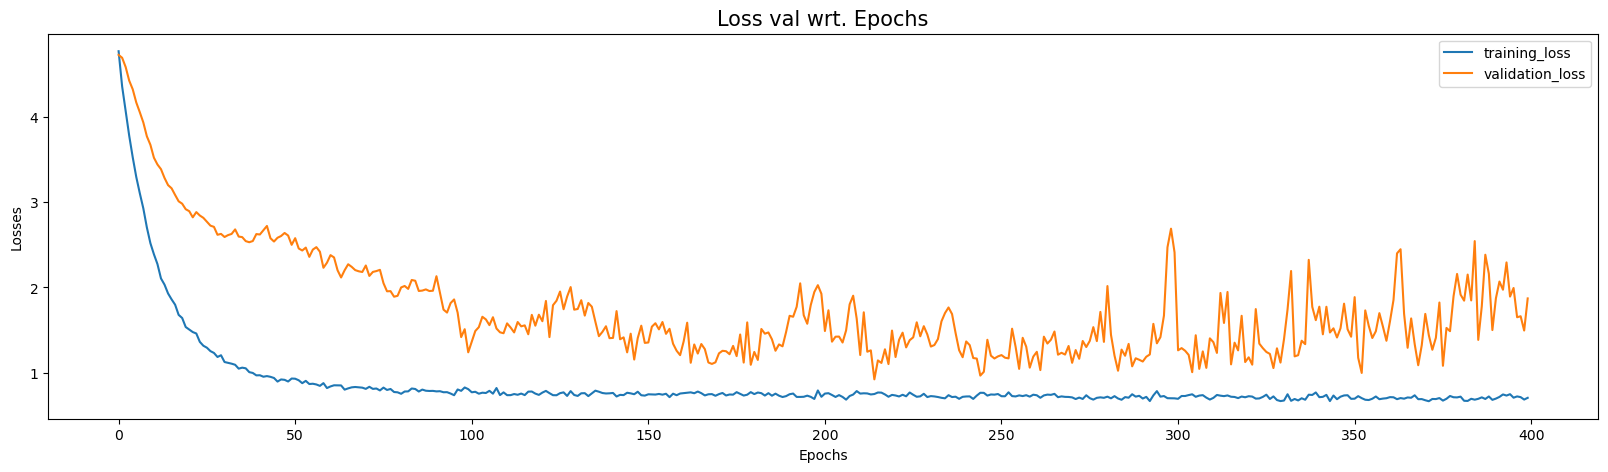

In [72]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))

2/2 [==============================] - 0s 10ms/step
Accuracy : 0.3392857142857143
              precision    recall  f1-score   support

      benign       0.89      0.36      0.52        22
      normal       0.22      1.00      0.36        10
   malignant       1.00      0.04      0.08        24

    accuracy                           0.34        56
   macro avg       0.70      0.47      0.32        56
weighted avg       0.82      0.34      0.30        56



# Resnet50 Model

In [74]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(498, 128, 128, 1) (498, 3) (56, 128, 128, 1) (56,)


## Again performing train-test split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size = 0.1, shuffle = True, random_state = 1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(498, 128, 128, 1)
(498, 3)
(56, 128, 128, 1)
(56, 3)


In [76]:
# converting single channel to 3 channel|
X_train = np.concatenate([X_train]*3, axis=-1)
X_test = np.concatenate([X_test]*3, axis=-1)

In [77]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))
resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


### Compiling and training our model


In [78]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
checkp = ModelCheckpoint('./valid_classifier_resnet50_version3.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
history1 = resnet_model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/400
8/8 [==============================] - ETA: 0s - loss: 1.1608 - accuracy: 0.3655
Epoch 1: val_loss improved from inf to 1.02823, saving model to ./valid_classifier_resnet50_version3.h5
8/8 [==============================] - 10s 691ms/step - loss: 1.1608 - accuracy: 0.3655 - val_loss: 1.0282 - val_accuracy: 0.4286
Epoch 2/400
8/8 [==============================] - ETA: 0s - loss: 1.0889 - accuracy: 0.4056
Epoch 2: val_loss improved from 1.02823 to 1.01993, saving model to ./valid_classifier_resnet50_version3.h5
8/8 [==============================] - 3s 377ms/step - loss: 1.0889 - accuracy: 0.4056 - val_loss: 1.0199 - val_accuracy: 0.3929
Epoch 3/400
8/8 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.3916
Epoch 3: val_loss improved from 1.01993 to 0.99728, saving model to ./valid_classifier_resnet50_version3.h5
8/8 [==============================] - 3s 349ms/step - loss: 1.0575 - accuracy: 0.3916 - val_loss: 0.9973 - val_accuracy: 0.4286
Epoch 4/400
8

Y test is:  (56, 3)
2/2 [==============================] - 1s 44ms/step
[[2.14858919e-01 6.56696498e-01 1.28444582e-01]
 [2.67844677e-01 8.44091363e-03 7.23714411e-01]
 [7.26993144e-01 8.19393527e-03 2.64812887e-01]
 [2.82914996e-01 6.81119598e-03 7.10273802e-01]
 [6.07501924e-01 1.46968290e-01 2.45529816e-01]
 [4.35322016e-01 1.41841382e-01 4.22836572e-01]
 [3.92259449e-01 3.38498503e-01 2.69242048e-01]
 [1.91650271e-01 6.20238245e-01 1.88111454e-01]
 [3.67685825e-01 2.11928457e-01 4.20385718e-01]
 [2.68077344e-01 5.10463297e-01 2.21459344e-01]
 [2.55010456e-01 5.86005330e-01 1.58984244e-01]
 [5.70172369e-01 1.69127941e-01 2.60699689e-01]
 [2.21840054e-01 6.43239975e-01 1.34920031e-01]
 [7.43539155e-01 4.18136679e-02 2.14647174e-01]
 [3.41069192e-01 5.52528398e-03 6.53405547e-01]
 [5.84627092e-01 3.96399666e-03 4.11408901e-01]
 [1.74906835e-01 1.31148775e-03 8.23781669e-01]
 [3.17211956e-01 2.27711964e-02 6.60016835e-01]
 [3.78004432e-01 3.56520057e-01 2.65475541e-01]
 [7.68367350e-01

Text(0.5, 192.72222222222217, 'Predicted')

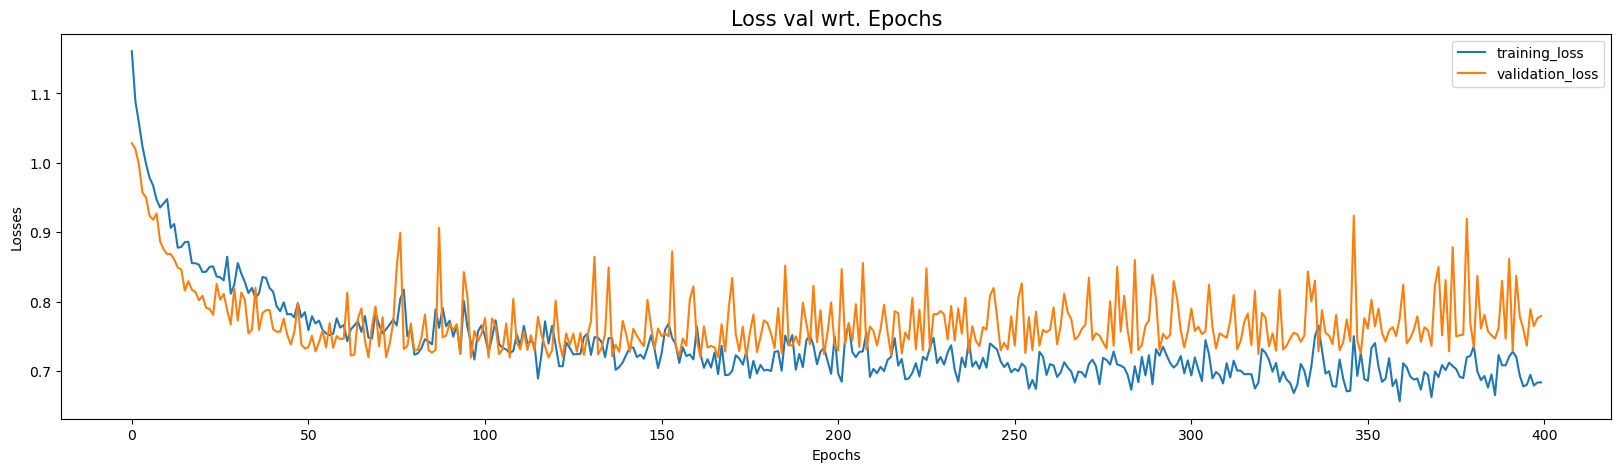

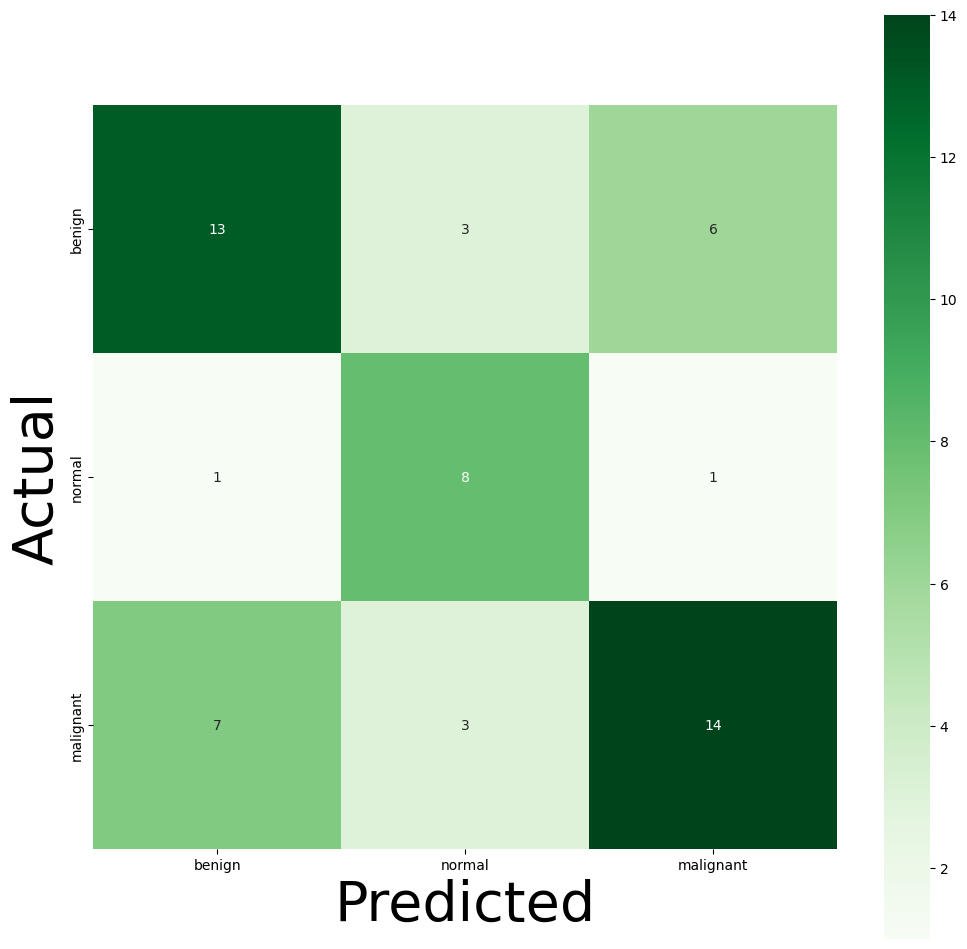

In [80]:
from sklearn.metrics import accuracy_score
plt.figure(figsize = (20,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

print("Y test is: ",y_test.shape)
model = keras.models.load_model('./valid_classifier_resnet50_version3.h5')
y_pred = model.predict(X_test)
print(y_pred)
y_pred = np.argmax(y_pred,axis=1)
print("y_pred shape; ", y_pred.shape)
print("y_test shape; ", y_test.shape)
y_test = np.argmax(y_test,axis=1)

print("y_test shape after argmax; ", y_test.shape)
# Getting accuracy and classification respot
print(accuracy_score(y_test, y_pred))
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Let us test our model on some images

1/1 [==============================] - 2s 2s/step
[0 0 0 0 1 1 1 2 2 2]


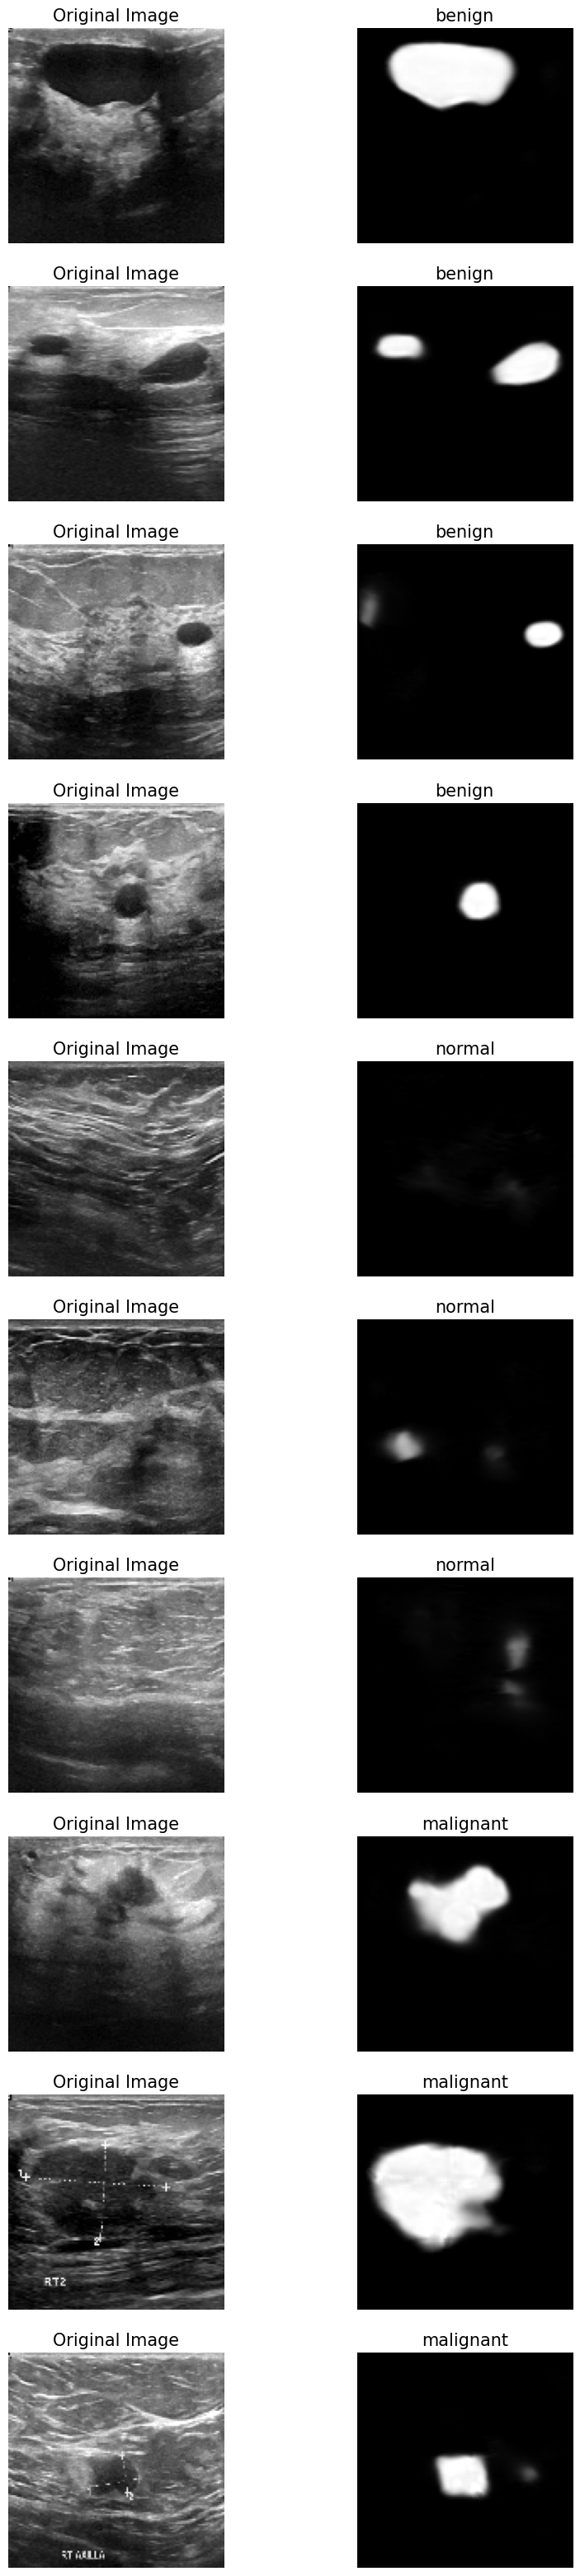

In [81]:
image_path = [
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (110).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (101).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (107).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (101).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (111).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (106).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (115).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (111).png',
    '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (110).png',
]

localize = load_model('/kaggle/working/finalunet.h5')
classifier = load_model('./valid_classifier_resnet50_version3.h5')

testX = []
for img in image_path :
    testX.append(cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), (128,128)))

testX = np.array(testX)

testX = testX.astype('float32') / 255.0

# Localizing the cancer using the segmentation model
predY = localize.predict(testX)


predY = np.stack((predY,)*3, axis=-1)  # stack the array
predY = np.squeeze(predY)  # remove extra dimension

# Classifying the cancer using the classifier model
pred_label = classifier.predict(predY)

print(np.argmax(pred_label, axis = 1))
plt.figure(figsize = (10,40))

i = 0
j = 0
while i < 20 :
    
    plt.subplot(10,2,i+1)
    plt.imshow (testX[j], 'gray')
    plt.title('Original Image', fontsize = 15)
    plt.axis('off')
    
    plt.subplot(10,2,i+2)
    plt.imshow (predY[j], 'gray')
    plt.title(f'{info[np.argmax(pred_label[j])]}', fontsize = 15)
    plt.axis('off')
    
    j += 1
    i += 2
plt.show()

From the above images, we can see that our model is performing quite well.

# ResNet101 Model

## Train Test Split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size = 0.1, shuffle = True, random_state = 1)

In [83]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(498, 128, 128, 1) (498, 3) (56, 128, 128, 1) (56, 3)


In [84]:
resnet_model_101 = Sequential()
X_train = np.concatenate([X_train]*3, axis=-1)
X_test = np.concatenate([X_test]*3, axis=-1)
pretrained_model= tf.keras.applications.ResNet101(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model_101.add(pretrained_model)
resnet_model_101.add(Flatten())
resnet_model_101.add(Dense(512, activation='relu'))
resnet_model_101.add(Dense(3, activation='softmax'))
resnet_model_101.summary()

171446536/171446536 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 43,708,803
Trainable params: 1,050,627
Non-trainable params: 42,658,176
_________________________________________________________________


#### Compiling our model

In [85]:
resnet_model_101.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#### Training our model

In [86]:
checkp1 = ModelCheckpoint('./valid_classifier_resnet101_version3.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
history4 = resnet_model_101.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp1])

Epoch 1/400
8/8 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.3916
Epoch 1: val_loss improved from inf to 1.00264, saving model to ./valid_classifier_resnet101_version3.h5
8/8 [==============================] - 12s 679ms/step - loss: 1.0983 - accuracy: 0.3916 - val_loss: 1.0026 - val_accuracy: 0.4286
Epoch 2/400
8/8 [==============================] - ETA: 0s - loss: 1.0580 - accuracy: 0.4197
Epoch 2: val_loss did not improve from 1.00264
8/8 [==============================] - 2s 302ms/step - loss: 1.0580 - accuracy: 0.4197 - val_loss: 1.0089 - val_accuracy: 0.5536
Epoch 3/400
8/8 [==============================] - ETA: 0s - loss: 1.0040 - accuracy: 0.4257
Epoch 3: val_loss improved from 1.00264 to 0.93943, saving model to ./valid_classifier_resnet101_version3.h5
8/8 [==============================] - 4s 465ms/step - loss: 1.0040 - accuracy: 0.4257 - val_loss: 0.9394 - val_accuracy: 0.5357
Epoch 4/400
8/8 [==============================] - ETA: 0s - loss: 0.988

#### Let us see the accuracy score and prediction results

2/2 [==============================] - 2s 72ms/step
Accuracy : 0.6785714285714286
              precision    recall  f1-score   support

      benign       0.71      0.68      0.70        22
      normal       0.54      0.70      0.61        10
   malignant       0.73      0.67      0.70        24

    accuracy                           0.68        56
   macro avg       0.66      0.68      0.67        56
weighted avg       0.69      0.68      0.68        56



Text(0.5, 192.72222222222217, 'Predicted')

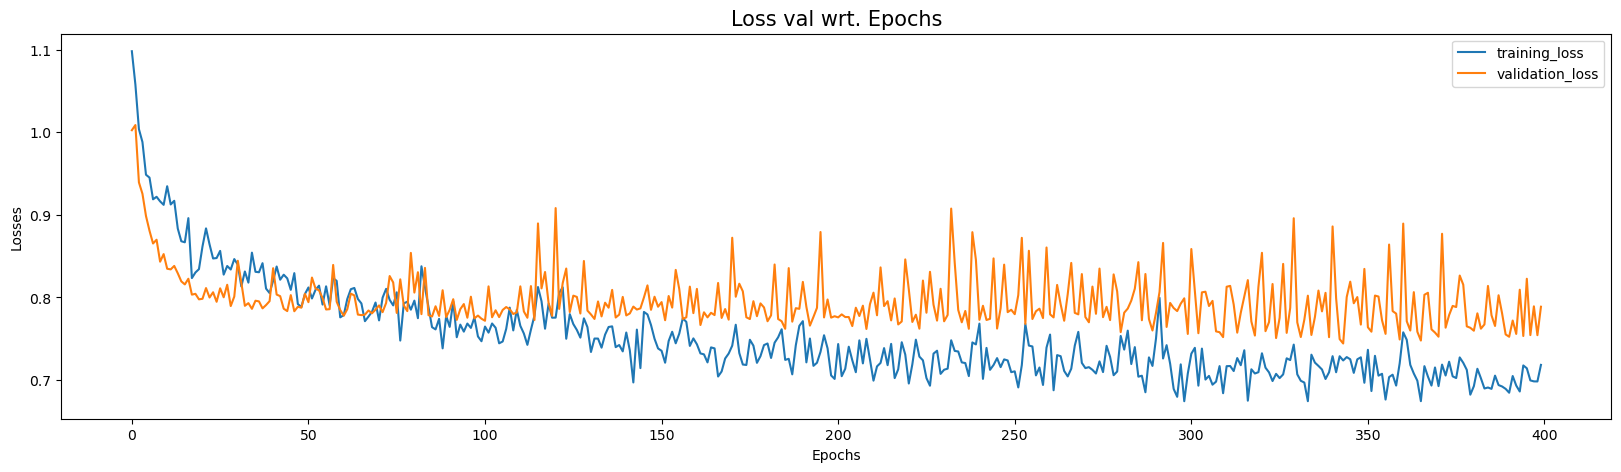

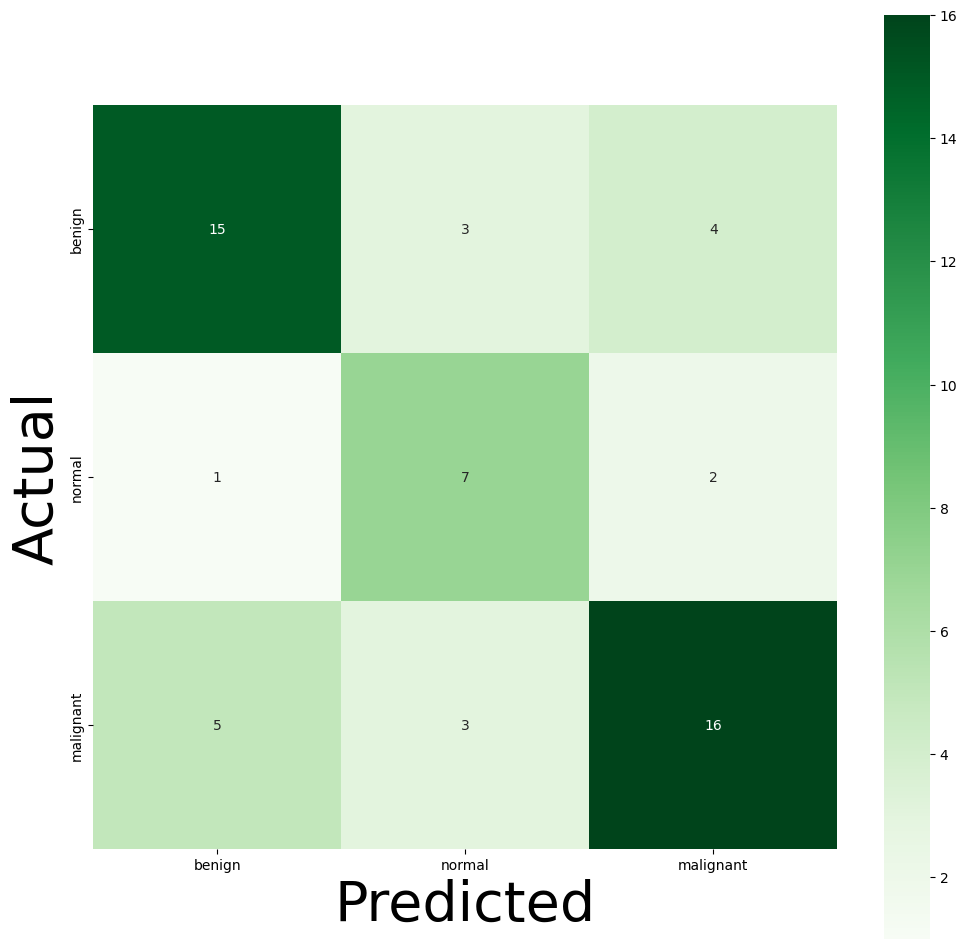

In [88]:
plt.figure(figsize = (20,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)


model = keras.models.load_model('./valid_classifier_resnet101_version3.h5')
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

# Getting accuracy and classification respot

print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

Here we can see that we are getting around 67.85% accuracy on our ResNet101 model.

In [115]:
base_model =tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128, 128, 3),
    pooling=None,
    classes=1000,
    #classifier_activation="softmax",
)


for layer in base_model.layers:
    layer.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


#### Building DenseNet model

In [135]:
def DenseNet201():

    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc']) 
    
    return model

#### Initializing DenseNet201 model and printing model summary

In [137]:
densenet_model = DenseNet201()
densenet_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_10 (Flatten)        (None, 30720)             0         
                                                                 
 batch_normalization_10 (Bat  (None, 30720)            122880    
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 512)               15729152  
                                                                 
 dropout_51 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               131328    
                                                     

In [138]:
densenet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
checkp = ModelCheckpoint('./valid_classifier_densenet201_version3.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
history1 = resnet_model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 400, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/400
8/8 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.6948
Epoch 1: val_loss improved from inf to 0.76281, saving model to ./valid_classifier_densenet201_version3.h5
8/8 [==============================] - 3s 343ms/step - loss: 0.6836 - accuracy: 0.6948 - val_loss: 0.7628 - val_accuracy: 0.6071
Epoch 2/400
8/8 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.6988
Epoch 2: val_loss improved from 0.76281 to 0.73717, saving model to ./valid_classifier_densenet201_version3.h5
8/8 [==============================] - 3s 348ms/step - loss: 0.6935 - accuracy: 0.6988 - val_loss: 0.7372 - val_accuracy: 0.6607
Epoch 3/400
8/8 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.7149
Epoch 3: val_loss did not improve from 0.73717
8/8 [==============================] - 2s 282ms/step - loss: 0.6896 - accuracy: 0.7149 - val_loss: 0.7747 - val_accuracy: 0.6071
Epoch 4/400
8/8 [==============================] - ETA: 0s - loss: 0.

Y test is:  (56, 3)
2/2 [==============================] - 3s 44ms/step
[[1.90213993e-01 6.68857634e-01 1.40928328e-01]
 [1.89463928e-01 1.79168042e-02 7.92619228e-01]
 [5.42493463e-01 5.58906468e-03 4.51917440e-01]
 [2.07517132e-01 2.14276370e-02 7.71055222e-01]
 [7.13371992e-01 7.16028810e-02 2.15025127e-01]
 [3.73444378e-01 1.23845056e-01 5.02710581e-01]
 [5.17122984e-01 2.23457649e-01 2.59419352e-01]
 [1.72153696e-01 6.52016342e-01 1.75829947e-01]
 [4.17069674e-01 2.01269120e-01 3.81661236e-01]
 [2.40857497e-01 4.89925712e-01 2.69216746e-01]
 [2.49314785e-01 5.59496045e-01 1.91189155e-01]
 [5.69576919e-01 1.68124303e-01 2.62298763e-01]
 [1.99062601e-01 6.53915584e-01 1.47021770e-01]
 [9.14063871e-01 5.68325864e-03 8.02528188e-02]
 [2.74046779e-01 1.08871721e-02 7.15066075e-01]
 [4.76050526e-01 3.92896077e-03 5.20020545e-01]
 [1.73441246e-01 2.61937920e-03 8.23939443e-01]
 [1.84720725e-01 1.87872946e-02 7.96491981e-01]
 [3.10899436e-01 3.84210765e-01 3.04889798e-01]
 [8.37810695e-01

Text(0.5, 192.72222222222217, 'Predicted')

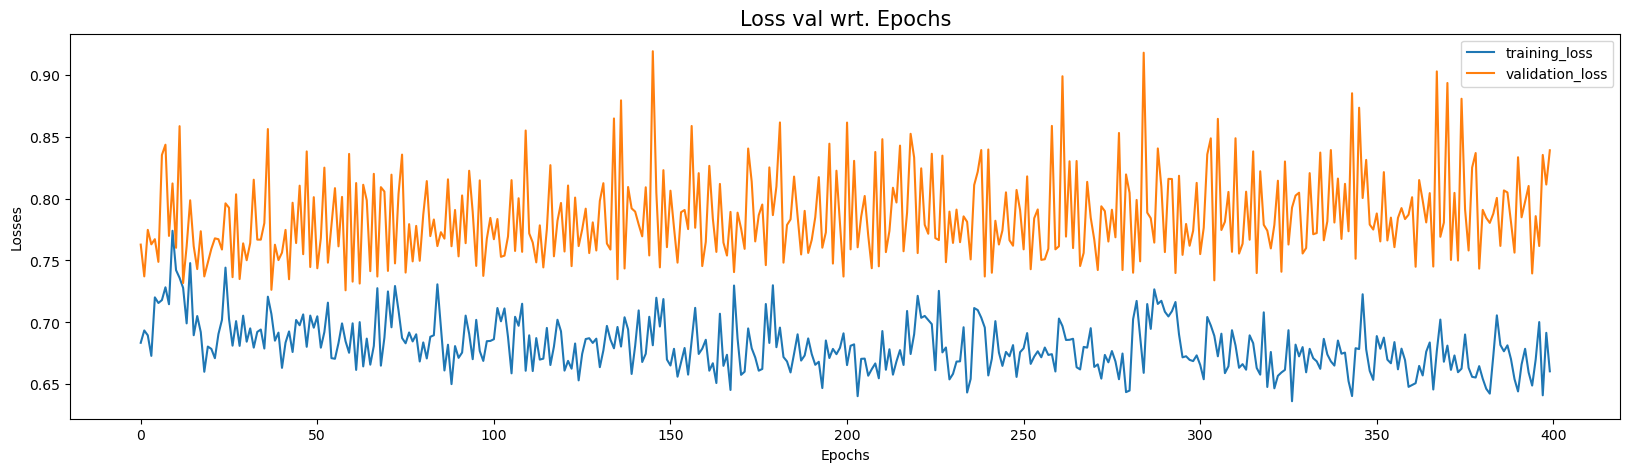

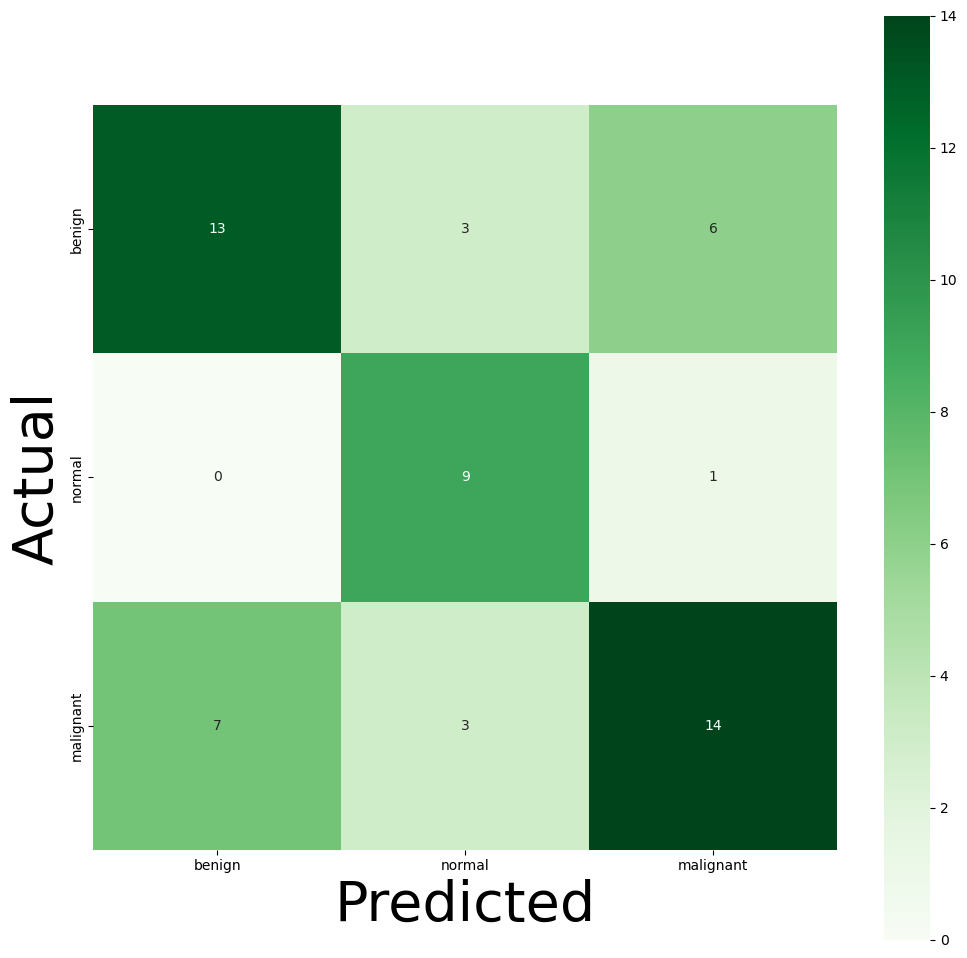

In [139]:
from sklearn.metrics import accuracy_score
plt.figure(figsize = (20,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

print("Y test is: ",y_test.shape)
model = keras.models.load_model('/kaggle/working/valid_classifier_densenet201_version3.h5')
y_pred = model.predict(X_test)
print(y_pred)
y_pred = np.argmax(y_pred,axis=1)
print("y_pred shape; ", y_pred.shape)
print("y_test shape; ", y_test.shape)
y_test = np.argmax(y_test,axis=1)

print("y_test shape after argmax; ", y_test.shape)
# Getting accuracy and classification respot
print(accuracy_score(y_test, y_pred))
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)